# NDA_COURSEWORK Part 2

In [ ]:
# importing the necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import osmnx as ox
import networkx as nx
from shapely.geometry import box
import random
import spaghetti as sp
import esda

## Task A: Spatial Networks and Planarity

### Loading and Preparing Accident Data (2010–2019)

To begin our analysis, we load and combine traffic accident datasets for the years 2010 to 2019. After loading, we drop any rows without coordinate information and convert the data into a GeoDataFrame, reprojecting it from the British National Grid (EPSG:27700) to WGS84 (EPSG:4326) for spatial analysis and mapping.

In [45]:
# Function to load and combine accident data from multiple years
def load_accident_data(data_dir, years):
    data_frames = []
    for year in years:
        # Handling different filenames
        if year == 2016:
            filename = "Copy%20of%20Leeds_RTC_2016.csv"
        elif year == 2017:
            filename = "Leeds_RTC_2017.csv"
        elif year == 2018:
            filename = "RTC%202018_Leeds.csv"
        elif year == 2019:
            filename = "Traffic%20accidents_2019_Leeds.csv"
        else:
            filename = f"{year}.csv"
        
        file_path = "{}/{}".format(data_dir,filename)
        df = pd.read_csv(file_path, encoding="ISO-8859-1")
        data_frames.append(df)

    # Combining all datasets
    df_all = pd.concat(data_frames, ignore_index=True)

    # Dropping rows with missing coordinates
    df_all = df_all.dropna(subset=["Grid Ref: Easting", "Grid Ref: Northing"])

    # Converting to GeoDataFrame (from British National Grid to WGS84)
    gdf = gpd.GeoDataFrame(
        df_all,
        geometry=gpd.points_from_xy(df_all["Grid Ref: Easting"], df_all["Grid Ref: Northing"]),
        crs="EPSG:27700"
    ).to_crs(epsg=4326)

    return gdf

### Preview Accident Data

Accident data from 2010–2019 is loaded and combined into a single GeoDataFrame. We preview the first few rows to verify the structure.

In [46]:
# Loading accident data from 2010 to 2019
years = list(range(2010, 2020))
data_directory = "../data/part2"
accidents_gdf = load_accident_data(data_directory, years)

# Printing the head of accidents dataframe
accidents_gdf.head()

,Reference Number,Easting,Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,...,Unnamed: 15,Expr1,1st Road Class & No,Accident Fields_Reference Number,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No,geometry
8199,130021591,NaN,NaN,3,15-Jan-13,1545,Unclassified,Dry,Daylight: street lights present,Fine without high winds,...,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.59184 53.79652)
8200,130021629,NaN,NaN,2,15-Jan-13,1640,A,Frost / Ice,Darkness: street lights present and lit,Other,...,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.63062 53.90457)
8201,130021704,NaN,NaN,2,13-Jan-13,1345,Unclassified,Wet / Damp,Daylight: street lights present,Fine without high winds,...,Motorcycle over 125cc and up to 500cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.62965 53.8164)
8202,130022047,NaN,NaN,1,15-Jan-13,1313,Unclassified,Dry,Daylight: street lights present,Fine without high winds,...,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.54183 53.78723)
8203,130023385,NaN,NaN,1,16-Jan-13,2015,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,...,Bus or coach (17 or more passenger seats),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.54036 53.79679)


### Selecting 1 km² Area in Central Leeds

We manually define a 1 km² bounding box around central Leeds using approximate coordinates from Google Maps. We then count how many accidents fall within this area to ensure it meets the requirement of at least 300 incidents.

In [47]:

# Defining manual central coordinates in Leeds (Picking coordinates from google maps near to center of leads)
center_lat, center_lon = 53.798928, -1.536309  

# Defining a ~1 km² box around the center (0.0045° ≈ 0.5 km)
buffer = 0.0045
north, south = center_lat + buffer, center_lat - buffer
east, west = center_lon + buffer, center_lon - buffer
selected_box = box(west, south, east, north)

# Counting accidents within the selected box
accidents_in_box = accidents_gdf[accidents_gdf.geometry.within(selected_box)]
print("Number of accidents in 1 km² around selected point:", len(accidents_in_box))


Number of accidents in 1 km² around selected point: 425


### Visualising Accidents in Selected Area

We plot all accidents across Leeds in light gray and highlight those within the selected 1 km² central area in red with a cyan boundary.

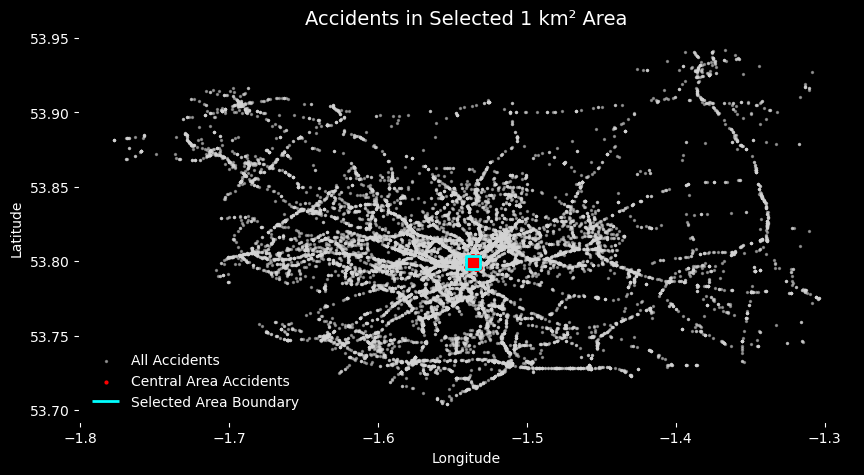

In [48]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')  # large fig, dark mode

# Plot all accidents in light gray
accidents_gdf.plot(
    ax=ax,
    color='lightgray',
    alpha=0.5,
    markersize=2,
    label='All Accidents'
)

# Highlight accidents inside the selected 1 km² box in red
accidents_gdf[accidents_gdf.within(selected_box)].plot(
    ax=ax,
    color='red',
    markersize=4,
    label='Central Area Accidents'
)

# Draw the boundary of the selected 1 km² cell in cyan
gpd.GeoSeries([selected_box]).boundary.plot(
    ax=ax,
    color='cyan',
    linewidth=2,
    label='Selected Area Boundary'
)

# Set title and labels with white text
plt.title("Accidents in Selected 1 km² Area", fontsize=14, color='white')
plt.xlabel("Longitude", color='white')
plt.ylabel("Latitude", color='white')

# Customize ticks and axes for black background
ax.tick_params(colors='white')
ax.set_facecolor('black')

# Add legend
ax.legend(frameon=False, labelcolor='white', fontsize=10)

plt.show()

### Extracting and Plotting Selected Road Network (~1 km²)

We use `osmnx.graph_from_point()` to extract the drivable road network within ~500m of the selected center point, forming approximately a 1 km² area.

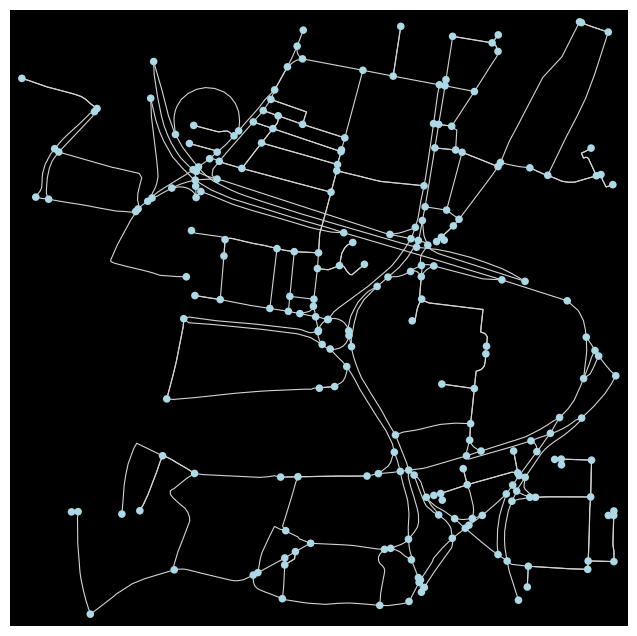

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [49]:
# Use graph_from_point to extract ~1 km² network
road_graph = ox.graph.graph_from_point(center_point=(center_lat, center_lon), dist=500, network_type='drive')

# Project to UTM for accurate spatial analysis. 
road_graph_proj = ox.projection.project_graph(road_graph)

# Plotting the road network with custom styling
ox.plot.plot_graph(
    road_graph_proj,
    bgcolor='black',            # Dark background
    node_size=30,               # Size of intersection points
    node_color="lightblue",     # Color of the nodes
    edge_linewidth=0.8,         # Thickness of road segments
    edge_color="lightgray"      # Color of road segments
)

### Computing Road Network Metrics

We define a function to calculate key statistics for the projected road network. These include:
- Average street length
- Node, edge, and intersection density
- Network diameter (based on the largest connected component)
- Circuitry (edge length relative to distance from centroid)
- Number of connected components
- Planarity and a counterexample if the network is non-planar

This function returns a dictionary of metrics.

In [50]:
def compute_network_stats(G_proj, area_m2=1_000_000):
    stats = ox.basic_stats(G_proj, area=area_m2)

    # Counting connected components
    n_components = nx.number_connected_components(G_proj.to_undirected())

    # Largest connected component for diameter
    largest_cc = max(nx.connected_components(G_proj.to_undirected()), key=len)
    subgraph = G_proj.subgraph(largest_cc)
    diameter = nx.diameter(subgraph.to_undirected())

    # Circuitry calculation
    total_edge_len = stats["edge_length_total"]
    nodes_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=False)
    centroid = nodes_proj.unary_union.centroid
    euclid_dists = [centroid.distance(pt) for pt in nodes_proj.geometry]
    euclid_sum = np.sum(euclid_dists)
    circuitry = total_edge_len / euclid_sum if euclid_sum > 0 else None

    # Planarity check
    is_planar, counterexample = nx.check_planarity(G_proj.to_undirected(), counterexample=True)

    return {
        "avg_street_length": stats["street_length_avg"],
        "node_density": stats["node_density_km"],
        "edge_density": stats["edge_density_km"],
        "intersection_density": stats["intersection_density_km"],
        "diameter": diameter,
        "circuitry": circuitry,
        "is_planar": is_planar,
        "planarity_counterexample": counterexample,
        "connected_components": n_components
    }

# Computing metrics for road network
network_metrics = compute_network_stats(road_graph_proj)

/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/2826799979.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = nodes_proj.unary_union.centroid


### Printing and Visualise Road Network Metrics

This function prints the computed road network metrics.


Road Network Metrics:
Num of Connected Components: 1
Spatial Diameter: 27
Average Street Length: 62.201 meters
Node Density: 231.000 nodes/km²
Edge Density: 23890.382 edges/km²
Intersection Density: 204.000 intersections/km²
Average Circuitry: 0.304
Is the Network Planar?: No

Following is a counterexample causing non-planarity:


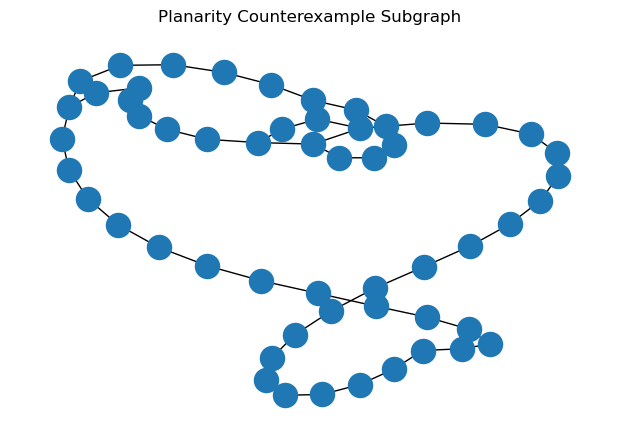

In [51]:
def print_network_metrics(metrics):
    print("\nRoad Network Metrics:")
    print(f"Num of Connected Components: {metrics['connected_components']}")
    print(f"Spatial Diameter: {metrics['diameter']}")
    print(f"Average Street Length: {metrics['avg_street_length']:.3f} meters")
    print(f"Node Density: {metrics['node_density']:.3f} nodes/km²")
    print(f"Edge Density: {metrics['edge_density']:.3f} edges/km²")
    print(f"Intersection Density: {metrics['intersection_density']:.3f} intersections/km²")
    print(f"Average Circuitry: {metrics['circuitry']:.3f}")
    
    if metrics["is_planar"]:
        print("Is the Network Planar?: Yes")
    else:
        print("Is the Network Planar?: No")
        print("\nFollowing is a counterexample causing non-planarity:")
        plt.figure(figsize=(6, 4))
        nx.draw(metrics["planarity_counterexample"])
        plt.title("Planarity Counterexample Subgraph")
        plt.show()


# Displaying the metrics
print_network_metrics(network_metrics)

# Task B: Road Accidents

### Prepare Network and Snap Accident Data

We convert the projected road network edges into a format compatible with the Spaghetti library and create a spatial network. Accident points are reprojected to match the network CRS and then snapped onto the network to enable spatial analysis.

In [ ]:
# Converting the projected edges to spaghetti-compatible format
edges_proj = ox.graph_to_gdfs(road_graph_proj, nodes=False)

# Creating the network from edges
network = sp.Network(in_data=edges_proj)

accidents_in_box_proj = accidents_in_box.to_crs(road_graph_proj.graph['crs'])

# Snapping reprojected accident points to the network
network.snapobservations(accidents_in_box_proj, 'accidents')

/opt/anaconda3/lib/python3.12/site-packages/spaghetti/network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/opt/anaconda3/lib/python3.12/site-packages/spaghetti/util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/opt/anaconda3/lib/python3.12/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


### Plot Original Accident Locations

We visualise the original accident points (before snapping) over the road network.

Observation 1:
True coords:    (596140.8692548554, 5961901.214843292)
Snapped coords: (596139.085927884, 5961901.955916537)


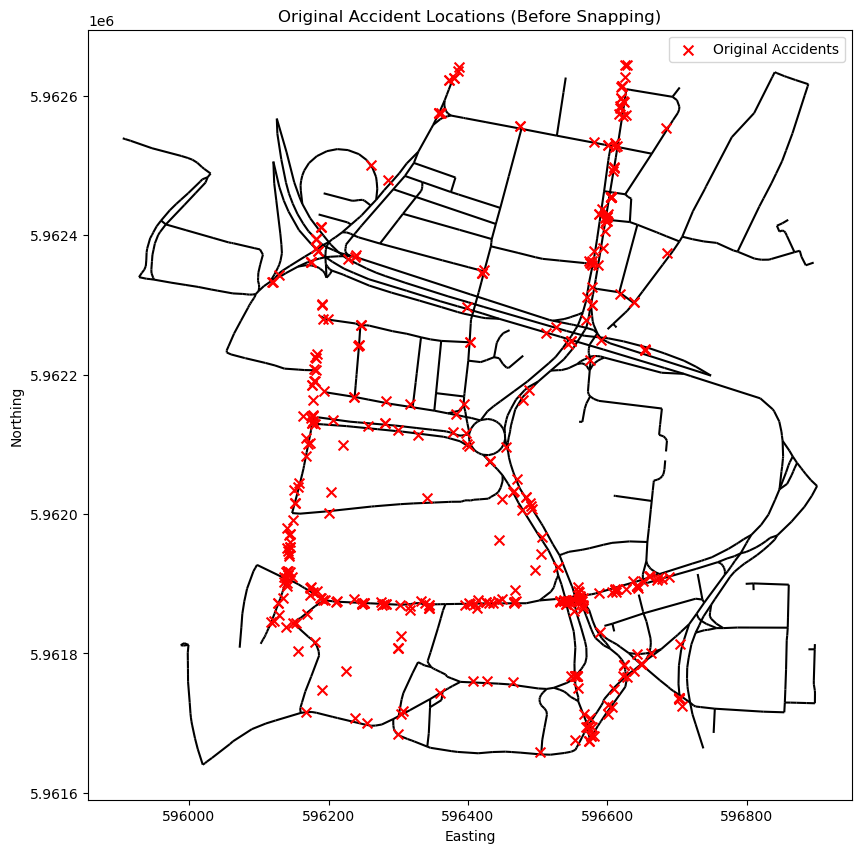

In [ ]:
# Getting node and edge GeoDataFrames from spaghetti
nodes_df, edges_df = sp.element_as_gdf(network, vertices=True, arcs=True)

# Plotting original (unsnapped) accidents
fig, ax = plt.subplots(figsize=(10, 10))
edges_df.plot(ax=ax, color="black", zorder=0)
sp.element_as_gdf(network, pp_name="accidents", snapped=False).plot(
    ax=ax, color="red", marker="x", markersize=50, zorder=1, label='Original Accidents'
)
plt.title("Original Accident Locations (Before Snapping)")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend()
plt.show()

### Plot Snapped Accidents on Network

We compare the original and snapped coordinates for accuracy, and then visualise all snapped accident points on the road network.

Observation 1:
True coords:    (596140.8692548554, 5961901.214843292)
Snapped coords: (596139.085927884, 5961901.955916537)


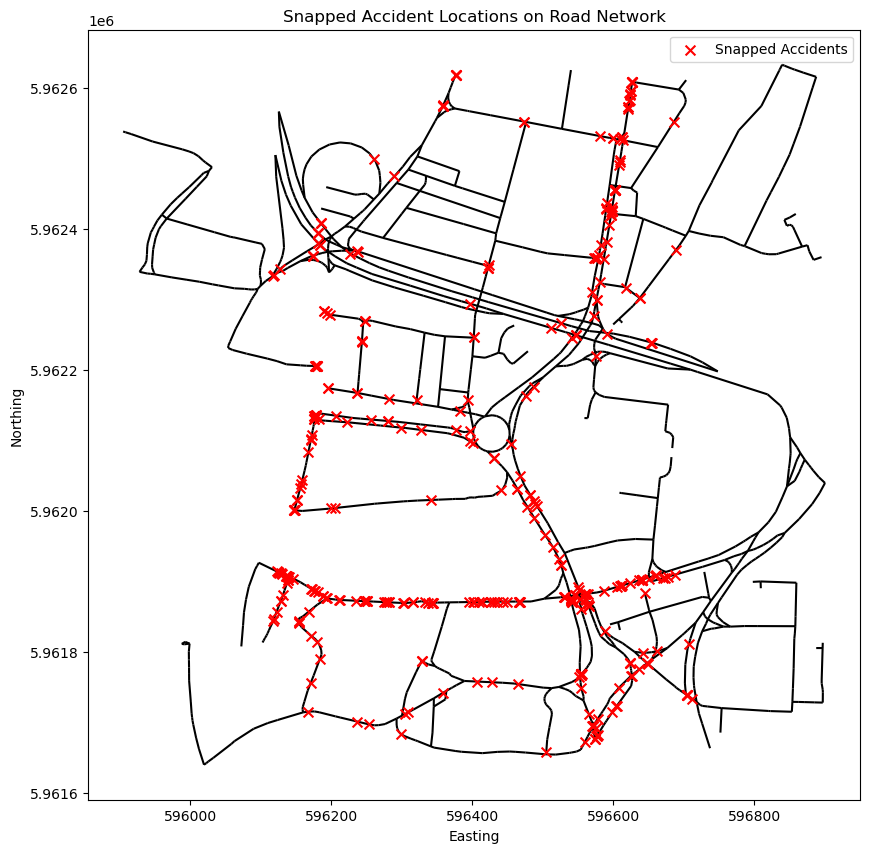

Number of accidents snapped to the network: 425


In [ ]:
# Printing coordinate comparison of first point
print("Observation 1:")
print("True coords:   ", network.pointpatterns["accidents"].points[0]["coordinates"])
print("Snapped coords:", network.pointpatterns["accidents"].snapped_coordinates[0])

# Plotting snapped accidents
fig, ax = plt.subplots(figsize=(10, 10))
edges_df.plot(ax=ax, color="black", zorder=0)
sp.element_as_gdf(network, pp_name="accidents", snapped=True).plot(
    ax=ax, color="red", marker="x", markersize=50, zorder=1, label='Snapped Accidents'
)
plt.title("Snapped Accident Locations on Road Network")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend()
plt.show()

# Count snapped points
num_snapped = len(network.pointpatterns["accidents"].points)
print("Number of accidents snapped to the network:", num_snapped)

### Analyze Accident Clustering with GlobalAutoK

We use `GlobalAutoK` to assess whether accidents are spatially clustered on the network. The observed K-function is compared against confidence envelopes generated through 100 random permutations. A higher observed K(r) value (above the upper envelope) indicates significant clustering at those distances. This helps us understand the scale and intensity of accident hotspots.

Density of points in the network (lambda): 0.02164909226029543
Distances at which density is measured:
[   0.           33.68730345   67.37460689  101.06191034  134.74921379
  168.43651723  202.12382068  235.81112412  269.49842757  303.18573102
  336.87303446  370.56033791  404.24764136  437.9349448   471.62224825
  505.3095517   538.99685514  572.68415859  606.37146203  640.05876548
  673.74606893  707.43337237  741.12067582  774.80797927  808.49528271
  842.18258616  875.86988961  909.55719305  943.2444965   976.93179994
 1010.61910339 1044.30640684 1077.99371028 1111.68101373 1145.36831718
 1179.05562062 1212.74292407 1246.43022752 1280.11753096 1313.80483441
 1347.49213786 1381.1794413  1414.86674475 1448.55404819 1482.24135164
 1515.92865509 1549.61595853 1583.30326198 1616.99056543 1650.67786887]


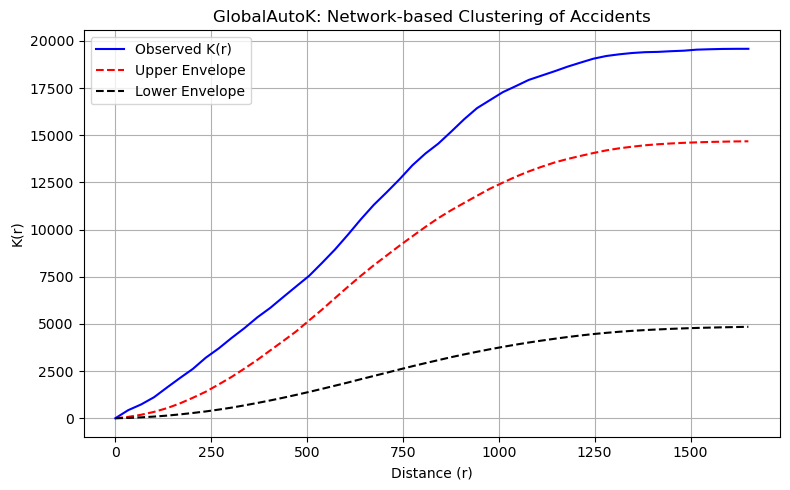

In [ ]:
# Computing the GlobalAutoK result using snapped points
kres = network.GlobalAutoK(
    network.pointpatterns["accidents"],
    nsteps=50,
    permutations=100
)

# Printing lambda (overall density) and distances
print(f"Density of points in the network (lambda): {kres.lam}")
print(f"Distances at which density is measured:\n{kres.xaxis}")

# Plotting observed vs envelopes
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(kres.xaxis, kres.observed, "b-", label="Observed K(r)")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper Envelope")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower Envelope")
ax.set_xlabel("Distance (r)")
ax.set_ylabel("K(r)")
ax.set_title("GlobalAutoK: Network-based Clustering of Accidents")
ax.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

We used GlobalAutoK to analyze clustering patterns in the snapped accident data along the Leeds city road network. The K-function evaluates how frequently accident points occur within different distances along the network compared to what would be expected under complete spatial randomness (CSR).

- The estimated density of accidents on the network is λ = 0.0216 accidents/meter, means there are relatively few accidents spread across the road network — typical in city-scale networks.

- The plot shows that the observed K(r) (blue) consistently exceeds the upper simulation envelope (red dashed line) across nearly all distances from 200m to 1500m.

- This clearly indicates statistically significant clustering of accidents on the network. 

The accidents are not randomly distributed, but instead tend to occur near each other, potentially near problematic intersections, busy road segments, or poorly designed infrastructure.


### Spatial Autocorrelation of Accidents (Moran’s I)

We compute **Moran’s I** to measure spatial autocorrelation of accident counts across road segments. Accident counts are assigned to each edge, and adjacency is defined using the network’s weights matrix. 

In [ ]:
# Getting the snapped point pattern
snapped_pointpatterns = network.pointpatterns['accidents']

# Counting the number of accidents per arc/road segment
counts = network.count_per_link(snapped_pointpatterns.obs_to_arc, graph=False)

# Accessing the network weights matrix
weights = network.w_network

# Getting edge identifiers in the weights matrix
edges = weights.neighbors.keys()

# Building list of values per edge in the same order as the weights
values = [
    counts[edge] if edge in counts else 0.0
    for edge in edges
]

# Computing Moran's I on the edge-based values
moran = esda.moran.Moran(values, weights)

# Printing results
print("Moran’s I:", round(moran.I, 4))
print("p-value:", round(moran.p_sim, 4))

Moran’s I: 0.1217
p-value: 0.003


A positive and significant Moran’s I value indicates that roads with many accidents tend to be near other accident-prone roads, revealing spatial clustering along connected segments.

- Moran’s I value was 0.1217, indicating a positive spatial autocorrelation.

- The p-value of 0.003 confirms this is statistically significant. (So we can reject the null hypothesis that accidents are randomly distributed.)

This means that road segments with a high number of accidents tend to be connected to other high-accident segments, forming spatial clusters of risk.

### Accident Proximity to Intersections

We calculate the distance from each snapped accident point to its nearest intersection (network node), and normalize these distances by the average road segment length. The resulting distribution shows whether accidents tend to occur near intersections or mid-segment.

/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/1905875061.py:16: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:32630

  distances = snapped_gdf.geometry.reset_index(drop=True).distance(nearest_geometries)


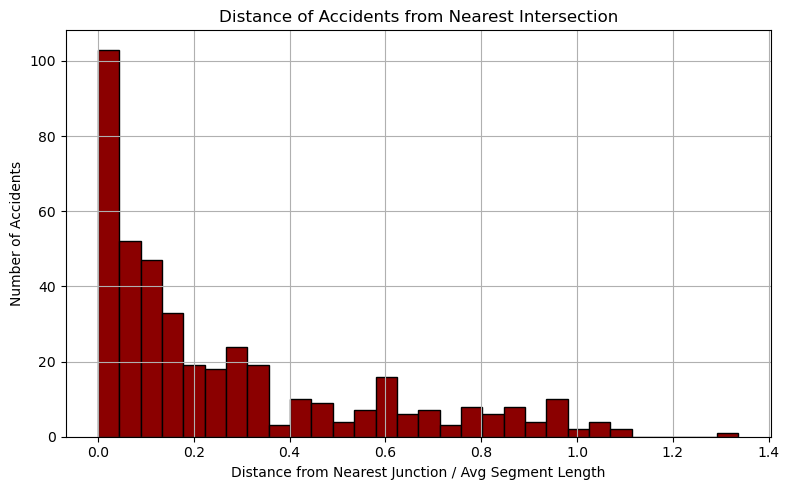

Mean normalized distance: 0.27
Max normalized distance: 1.34
Min normalized distance: 0.0


In [ ]:
# Get projected road network nodes (intersections)
nodes_proj = ox.graph_to_gdfs(road_graph_proj, nodes=True, edges=False)

# Getting snapped accident points from the network
snapped_gdf = sp.element_as_gdf(network, pp_name='accidents', snapped=True)

# Finding nearest intersection for each snapped accident
nearest_node_ids = snapped_gdf.geometry.apply(lambda pt: nodes_proj.distance(pt).idxmin())
nearest_geometries = nodes_proj.loc[nearest_node_ids].geometry.reset_index(drop=True)

# Computing distances from each accident to its nearest intersection
distances = snapped_gdf.geometry.reset_index(drop=True).distance(nearest_geometries)

# Normalizing distances by average road segment length
mean_edge_length = edges_proj['length'].mean()
normalized_distances = distances / mean_edge_length

# Plotting histogram of distances
plt.figure(figsize=(8, 5))
plt.hist(normalized_distances, bins=30, color='darkred', edgecolor='black')
plt.title("Distance of Accidents from Nearest Intersection")
plt.xlabel("Distance from Nearest Junction / Avg Segment Length")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()

# Printing Summary statistics
print("Mean normalized distance:", round(normalized_distances.mean(), 2))
print("Max normalized distance:", round(normalized_distances.max(), 2))
print("Min normalized distance:", round(normalized_distances.min(), 2))

“The majority of accidents occur near intersections, as the mean normalized distance was 0.27, and a substantial number of points were located within 20–30% of a segment’s length from an intersection.
 This suggests intersections are hotspots for accidents in the analyzed area of Leeds.”

# Task C: Voronoi Diagrams

### Load Full Leeds Road Network

We load the complete road network for Leeds using OpenStreetMap and project it to UTM coordinates.

In [241]:
def load_leeds_network(query="Leeds, United Kingdom", network_type="all"):
    # Load drivable road network from OpenStreetMap
    G = ox.graph_from_place(query, network_type=network_type, simplify=True)
    
    # Project to UTM for accurate spatial analysis
    G_proj = ox.project_graph(G)
    
    # Print summary
    print("Full Leeds road network loaded.")
    print(f" Nodes: {len(G_proj.nodes)}, Edges: {len(G_proj.edges)}")
    
    return G_proj

# Load and project the full Leeds graph
leeds_graph_proj = load_leeds_network()

Full Leeds road network loaded.
 Nodes: 105492, Edges: 267935


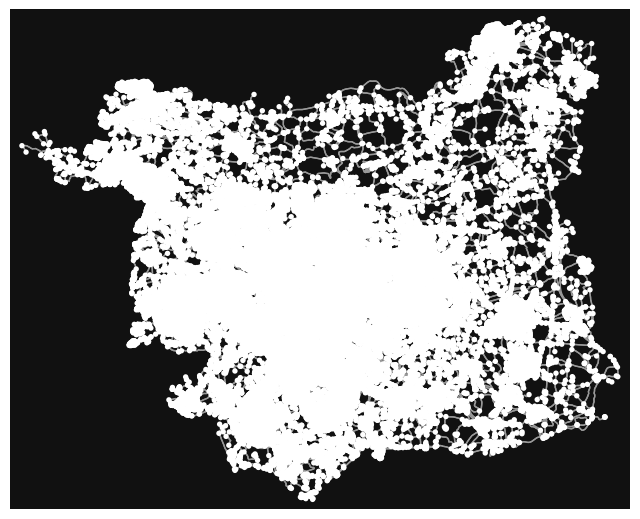

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [267]:
ox.plot_graph(leeds_graph_proj)

### Selecting Voronoi Seed Nodes

To divide Leeds into fair and balanced regions for marathon planning, we select 4 seed nodes by:
	•	Dividing the city into 4 quadrants using the spatial center of the network
	•	Computing the centroid of each quadrant based on the spatial distribution of road nodes
	•	Applying small adjustments to the centroids to improve spatial spread and avoid overlap
	•	Selecting the closest node to each (possibly nudged) centroid as the seed

These 4 nodes will act as seeds for generating a network-based Voronoi diagram.


In [ ]:
from shapely.geometry import Point

def get_quadrant_seed_nodes(G_proj):
    # Converting network graph to GeoDataFrames
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_proj)

    # Getting the bounding boxes
    xmin, ymin, xmax, ymax = nodes_gdf.total_bounds
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2

    # Dividing the map into 4 spatial quadrants
    quadrants = {
        'top_left': nodes_gdf[(nodes_gdf.x < x_center) & (nodes_gdf.y > y_center)],     # NW
        'top_right': nodes_gdf[(nodes_gdf.x >= x_center) & (nodes_gdf.y > y_center)],   # NE
        'bottom_left': nodes_gdf[(nodes_gdf.x < x_center) & (nodes_gdf.y <= y_center)], # SW
        'bottom_right': nodes_gdf[(nodes_gdf.x >= x_center) & (nodes_gdf.y <= y_center)] # SE
    }

    seed_nodes = []
    seed_coords = []

    # For each quadrant, find nearest node to (possibly nudged) centroid
    for name, quad_nodes in quadrants.items():
        if not quad_nodes.empty:
            centroid = quad_nodes.unary_union.centroid
            
            # Slightly adjusting the nodes to a more reasonable point
            if name == 'top_right':  # NE
                centroid = Point(centroid.x , centroid.y)
            elif name == 'top_left':  # SE
                centroid = Point(centroid.x + 1000, centroid.y - 300)
            elif name == 'bottom_right':  # SE
                centroid = Point(centroid.x + 1000, centroid.y + 350)
            elif name == 'bottom_left':  # SW
                centroid = Point(centroid.x + 500, centroid.y)

            # Finding the nearest node to the adjusted node
            closest_id = quad_nodes.geometry.distance(centroid).idxmin()
            seed_nodes.append(closest_id)
            seed_coords.append(quad_nodes.loc[closest_id].geometry)
            print(f"Selected seed in {name}: node {closest_id}")
        else:
            print(f"Quadrant {name} is empty!")

    return seed_nodes, seed_coords, nodes_gdf, edges_gdf

# Running the function to get voronoi seed nodes
selected_seed_nodes, seed_coords, nodes_gdf, edges_gdf = get_quadrant_seed_nodes(leeds_graph_proj)

Selected seed in top_left: node 7449383714
Selected seed in top_right: node 936632147
Selected seed in bottom_left: node 430952962
Selected seed in bottom_right: node 6321999459


/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/2163244479.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = q_nodes.unary_union.centroid
/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/2163244479.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = q_nodes.unary_union.centroid
/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/2163244479.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = q_nodes.unary_union.centroid
/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/2163244479.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = q_nodes.unary_union.centroid


### Plotting Voronoi Seeds on Leeds Road Network

This plot visualizes the entire Leeds road network with the selected Voronoi seed nodes overlaid in red. 

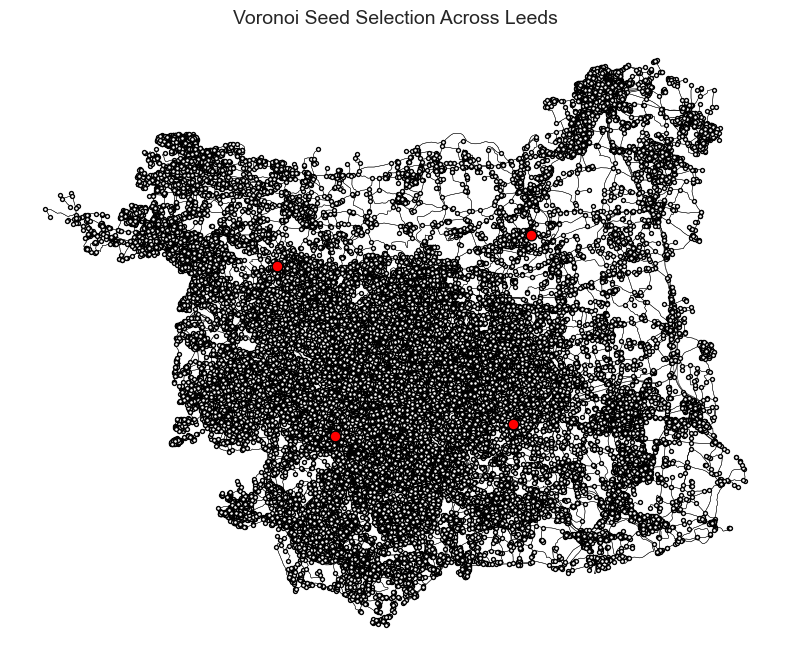

In [353]:
# Plot network and seeds
fig, ax = plt.subplots(figsize=(8, 8))
edges_gdf.plot(ax=ax, color='black', linewidth=0.3, zorder=0)
nodes_gdf.plot(ax=ax, color='white', edgecolor='black', markersize=8, zorder=1)

# Plotting the seed points
for pt in seed_coords:
    ax.scatter(pt.x, pt.y, s=60, color='red', edgecolors='black', zorder=2)

plt.title("Voronoi Seed Selection Across Leeds", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

### Construct and Plotting Voronoi Diagram over Road Network

Using the four selected seed nodes, we generate a Voronoi diagram based on shortest-path distances over the road network. Each node is assigned to its closest seed, and edges are colored by the region of their start node. This provides a visual partitioning of Leeds’ road network into 4 marathon zones.
The implementation of this code is taken from NDA Lab Week 4 and the code for computing voronoi has been optimized for faster computation, also the nodes irrespective of the seed points have assigned the same color of their edge for better visibility. 


Step 1: Computing shortest path distances (Dijkstra)
Step 2: Assigning nearest seed for each node
Step 3: Assigning color to every edge for all seeds


/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/3341419605.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', num_seeds)


Step 4: Plotting Voronoi network diagram


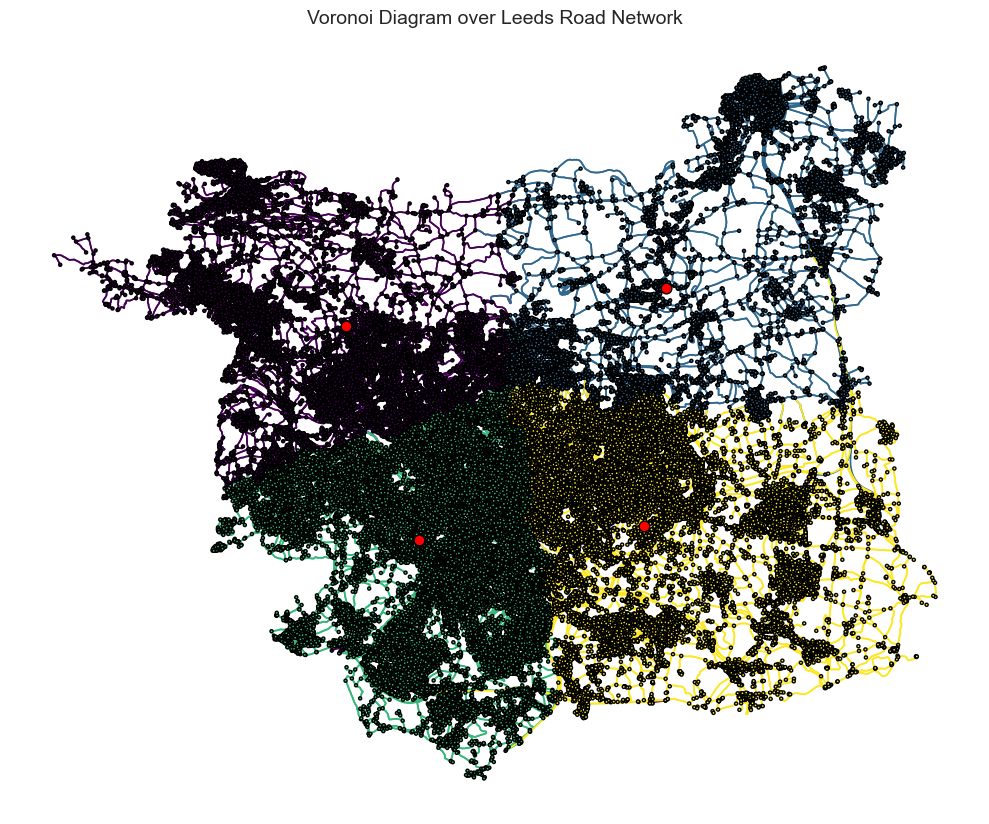

In [ ]:
# Function to generate edge-based Voronoi diagram over a road network
def compute_network_voronoi(G_proj, seed_nodes, nodes_gdf, edges_gdf):
    num_seeds = len(seed_nodes)
    print("\nStep 1: Computing shortest path distances (Dijkstra)")    
    # Step 1: Compute Dijkstra distances from each seed
    distances = {
        seed: nx.single_source_dijkstra_path_length(G_proj, seed, weight='length')
        for seed in seed_nodes
    }

    # Step 2: Assigning each node to its nearest seed
    print("Step 2: Assigning nearest seed for each node")
    node_to_seed = {
        node: min(
            [(seed, distances[seed].get(node, np.inf)) for seed in seed_nodes],
            key=lambda x: x[1]
        )[0]
        for node in G_proj.nodes
    }

    # Step 3: Assign each edge to the region of its start node
    print("Step 3: Assigning color to every edge for all seeds")
    edge_tuples = list(G_proj.edges(keys=True))
    edge_seed_assignment = [node_to_seed[u] for u, v, k in edge_tuples]

    # Step 4: Generating a color for each seed region using a color map
    cmap = cm.get_cmap('viridis', num_seeds)
    color_list = [cmap(i) for i in range(num_seeds)]
    seed_to_color = {seed: color_list[i] for i, seed in enumerate(seed_nodes)}
    # edge_colors = [seed_to_color[s] for s in edge_seed_assignment]

    # Step 5: Plot Voronoi diagram
    print("Step 4: Plotting Voronoi network diagram")
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting each group of colored edges belonging to a region
    edge_geoms = list(edges_gdf.geometry)
    for seed in seed_nodes:
        indices = [i for i, s in enumerate(edge_seed_assignment) if s == seed]
        segments = [edge_geoms[i] for i in indices]
        gpd.GeoSeries(segments).plot(ax=ax, color=seed_to_color[seed], linewidth=1.2, zorder=0)

    # Plotting nodes with the same color as their corresponding Voronoi region for better visibility of spread
    node_colors = [seed_to_color[node_to_seed[node]] for node in nodes_gdf.index]
    nodes_gdf.plot(ax=ax, color=node_colors, edgecolor='black', markersize=5, zorder=1)

    # Plotting the seed points 
    for pt in seed_coords:
        ax.scatter(pt.x, pt.y, s=60, color='red', edgecolors='black', zorder=2)

    plt.title("Voronoi Diagram over Leeds Road Network", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    return node_to_seed, seed_to_color

# Calling the function to compute voronoi diagram
node_to_seed, seed_to_color = compute_network_voronoi(
    leeds_graph_proj, selected_seed_nodes, nodes_gdf, edges_gdf)

### Generating Voronoi Subgraphs

Once each node is assigned to its closest seed node, we create subgraphs for each Voronoi cell. Each subgraph contains only the nodes and edges belonging to a specific Voronoi region. These will be used in the next steps to search for 42 km marathon loops within each region

In [ ]:
# Function to create subgraphs from the Voronoi node assignments
def create_voronoi_subgraphs(graph, node_to_seed, seed_nodes):
    seed_to_nodes = {}
    
    # Grouping all nodes by their assigned seed
    for node, assigned_seed in node_to_seed.items():
        seed_to_nodes.setdefault(assigned_seed, []).append(node)

    # Building subgraphs from grouped nodes
    subgraphs = {
        seed: graph.subgraph(seed_to_nodes[seed]).copy()
        for seed in seed_nodes
    }
    return subgraphs

# Generating the Voronoi subgraphs using the earlier computed assignments
voronoi_subgraphs = create_voronoi_subgraphs(leeds_graph_proj, node_to_seed, selected_seed_nodes)

### Finding Loops Approx (~42 km) in All Voronoi Cells 

We attempt to find a valid **looped path (~42 km)** in each Voronoi region by randomly selecting start and end nodes within the subgraph. The goal is to identify round trips within ±0.5 km of the marathon distance. In each cell, we keep the best loop found.

In [361]:
# Marathon target loop size
TARGET_DISTANCE = 42000  # 42 km in meters
TOLERANCE = 1000         # 1 km tolerance (±)

MIN_DIST = TARGET_DISTANCE - TOLERANCE
MAX_DIST = TARGET_DISTANCE + TOLERANCE


def finding_best_path_loop(graph, min_dist= MIN_DIST, max_dist=MAX_DIST, samples=50):
    best_path = None
    best_length = 0
    nodes = list(graph.nodes)

    # Sampling a subset of random nodes as sources
    sampled_sources = random.sample(nodes, min(samples, len(nodes)))

    for source in sampled_sources:
        try:
            #  Getting the shortest-path distances from this source
            lengths = nx.single_source_dijkstra_path_length(graph, source, weight='length')
            
            # Skipping nodes with very less neighbours because can possibly be a dead end. 
            if len(lengths) < 2:
                continue

            # Finding farthest node from this source
            target = max(lengths, key=lengths.get)
            if source == target: # Skip if the source and target are same
                continue

            # Building round-trip path (cycle)
            path1 = nx.shortest_path(graph, source=source, target=target, weight='length')
            path2 = nx.shortest_path(graph, source=target, target=source, weight='length')
            full_path = path1 + path2[1:]

            # Calculating the total length of bath
            total_length = sum(
                graph[u][v][0].get('length', 0)
                for u, v in zip(full_path[:-1], full_path[1:])
                if graph.has_edge(u, v)
            )

            # If path is between the MIN and MAX Limit Return Immediately
            if min_dist <= total_length <= max_dist:
                return full_path, total_length
            elif total_length > best_length: # Else continue to calculate the best path
                best_path, best_length = full_path, total_length

        except: # Incase of error avoid breaking the loop and find a different path
            continue

    return best_path, best_length


In [365]:
# Loop search across all Voronoi subgraphs
def find_loops_in_voronoi_subgraphs(voronoi_subgraphs, min_dist= MIN_DIST, max_dist=MAX_DIST, samples=50):
    loop_paths = {} # Dictionary to store loops
    max_len = 0

    for i, (seed, subgraph) in enumerate(voronoi_subgraphs.items()):
        print(f"\nCell {i+1}: Searching for a ~42 km loop...")
        path, length = finding_best_path_loop(subgraph, min_dist, max_dist, samples) # Finding the best path
        
        if(length>max_len):
            max_len=length
            print(f"Max found Path length till now:,{max_len/1000} km")

        if min_dist <= length <= max_dist:
            loop_paths[seed] = {'path': path, 'length': length}
            print(f"Valid loop found for marathon with length: {round(length/1000, 2)} km")
        elif length > 0:
            loop_paths[seed] = {'path': path, 'length': length}
            print(f"Maximum length loop found: {round(length/1000, 2)} km (outside tolerance)")
        else:
            print("No valid loop found.")

    return loop_paths

# Finding loops in each voronoi subgraphs
improved_loop_paths = find_loops_in_voronoi_subgraphs(voronoi_subgraphs,samples=300)


Cell 1: Searching for a ~42 km loop...
Max found Path length till now:,42.59216248638989 km
Valid loop found for marathon with length: 42.59 km

Cell 2: Searching for a ~42 km loop...
Valid loop found for marathon with length: 41.55 km

Cell 3: Searching for a ~42 km loop...
Maximum length loop found: 35.25 km (outside tolerance)

Cell 4: Searching for a ~42 km loop...
Maximum length loop found: 39.57 km (outside tolerance)


In [366]:
random.seed(42)
np.random.seed(42)

### Visualizing All Marathon Loops 

This function plots all marathon loops found in different Voronoi cells of the Leeds road network. Each loop is shown in a distinct color, and a legend is automatically created to display the distance of each loop.

/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/665170228.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', num_loops)


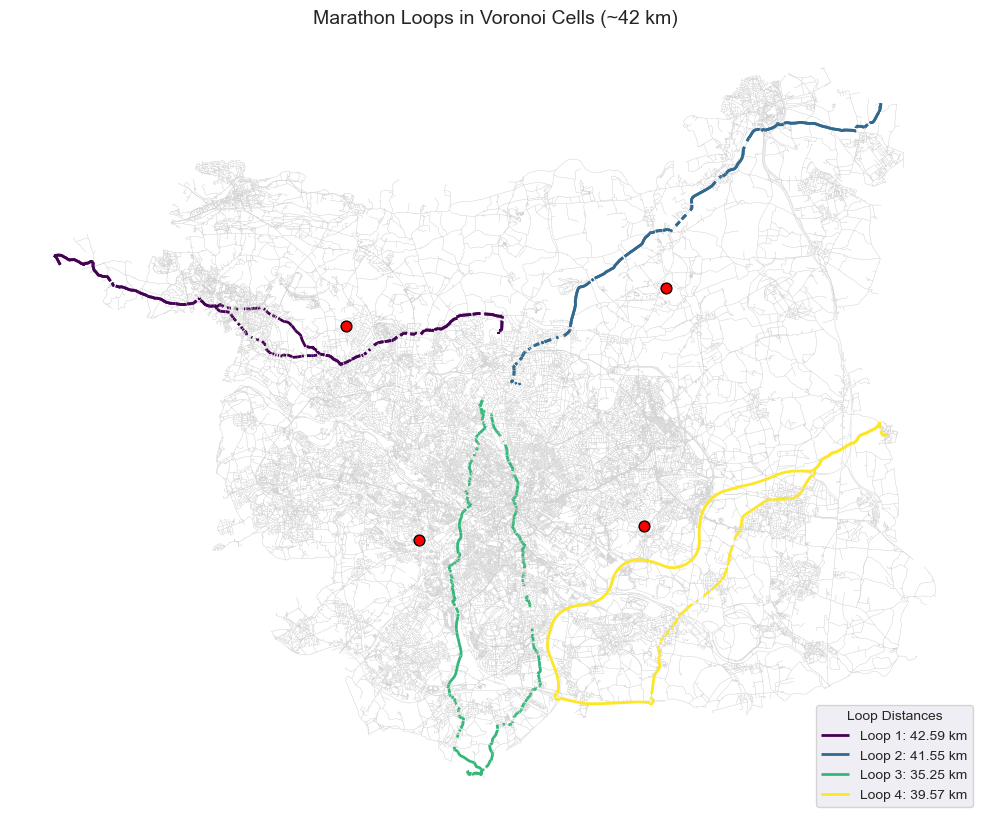

In [367]:
def plotting_marathon_loops(loop_paths, graph, nodes_gdf, edges_gdf, seed_nodes):
    # Setting up plot and background
    fig, ax = plt.subplots(figsize=(10, 10))
    edges_gdf.plot(ax=ax, color='lightgray', linewidth=0.2, zorder=0)

    # Using colormap to generate colors distinct colors for loops
    num_loops = len(loop_paths)
    cmap = cm.get_cmap('viridis', num_loops)
    colors = [cmap(i) for i in range(num_loops)]

    # Plotting each loop
    for i, (seed, data) in enumerate(loop_paths.items()):
        path_edges = list(zip(data['path'][:-1], data['path'][1:]))
        lines = []
        for u, v in path_edges:
            if graph.has_edge(u, v):
                edge_data = graph[u][v][0]
                if 'geometry' in edge_data:
                    lines.append(edge_data['geometry'])

        if lines:
            gpd.GeoSeries(lines).plot(ax=ax, linewidth=2, color=colors[i], zorder=1, label=f"Loop {i+1}: {data['length']/1000:.2f} km")

    # Plotting the seed nodes
    for s in seed_nodes:
        pt = nodes_gdf.loc[s].geometry
        ax.scatter(pt.x, pt.y, s=60, color='red', edgecolors='black', zorder=2)

    # Showing legend
    ax.legend(loc='lower right', title="Loop Distances")
    plt.title("Marathon Loops in Voronoi Cells (~42 km)", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
plotting_marathon_loops(improved_loop_paths, leeds_graph_proj, nodes_gdf, edges_gdf, selected_seed_nodes)

# Task D: TransE, PROV, PageRank

### Setup Provenance Document and Namespaces

In this step, we create the base structure for our provenance graph. We use the `ProvDocument` class from the `prov.model` library to store our agents, entities, and activities. We also define a few **namespaces** to make our identifiers more readable and organized. The Implementation of this model is inspired from NDA week 10 labs.

In [185]:
# Importing the ProvDocument class from the prov package
from prov.model import ProvDocument

# Creating an empty provenance document object to hold all nodes and relations
d1 = ProvDocument()

# Adding namespaces to group and simplify identifiers
d1.add_namespace('ex', 'http://example.org/')          # General namespace for activities
d1.add_namespace('person', 'http://example.org/person/')  # Namespace for agents (people involved)
d1.add_namespace('doc', 'http://example.org/doc/')     # Namespace for documents and other entities

<Namespace: doc {http://example.org/doc/}>

### Defining Agents (People Involved in the Marathon)

In this step, we define all the agents (i.e., people or organizations) involved in the marathon planning and execution process. Each agent is created using the `agent()` method with a clear `prov:label` to describe their role.

In [ ]:
# The mayor is in charge of planning and overseeing the event
mayor = d1.agent('person:mayor', {
    'prov:type': 'prov:Person',
    'prov:label': 'Mayor – Marathon Event Planner'
})

# Albert is responsible for managing and recruiting volunteers
albert = d1.agent('person:albert', {
    'prov:type': 'prov:Person',
    'prov:label': 'Albert – Volunteer Coordinator'
})

# Nitisha is the head of the medical team and manages first aid
nitisha = d1.agent('person:nitisha', {
    'prov:type': 'prov:Person',
    'prov:label': 'Nitisha – Medical Coordinator'
})

# Ammar is one of the runners participating in the marathon
ammar = d1.agent('person:ammar', {
    'prov:type': 'prov:Person',
    'prov:label': 'Ammar – Marathon Runner'
})

### Defining Activities (main processes involved in organizing and running the marathon)
Now we define the main activities involved in the marathon planning and execution. These are key actions or processes performed by agents and involving entities.

In [187]:
# Planning the marathon route
a1 = d1.activity('ex:plan-routes', None, None, {'prov:label': 'Planning Marathon Routes'})

# Recruiting and organizing volunteers
a2 = d1.activity('ex:organize-volunteers', None, None, {'prov:label': 'Organizing Volunteers'})

# Setting up water drinking stations along the route
a3 = d1.activity('ex:setup-water', None, None, {'prov:label': 'Setting Up Water Stations'})

# Reviewing and approving the permit for the marathon
a4 = d1.activity('ex:approve-permit', None, None, {'prov:label': 'Approving Marathon Permit'})

# Setting up first aid services for medical emergencies
a5 = d1.activity('ex:organize-first-aid', None, None, {'prov:label': 'Organizing First Aid'})

# The actual running of the marathon
a6 = d1.activity('ex:run-marathon', None, None, {'prov:label': 'Running the Marathon'})

### Define Entities (Documents and Plans)

Entities are the **things** involved in our process — such as documents, maps, plans, forms, or any resources used or produced during the marathon. Below, we define each entity with a unique ID and a label.

In [188]:
# Route planning and approval
e1 = d1.entity('doc:route-map', {'prov:label': 'Marathon Route Map'})
e2 = d1.entity('doc:permit-application', {'prov:label': 'Permit Application Form'})
e3 = d1.entity('doc:permit-doc', {'prov:label': 'Approved Marathon Permit'})

# Volunteer and water station prep
e4 = d1.entity('doc:volunteer-list', {'prov:label': 'List of Volunteers'})
e5 = d1.entity('doc:water-checklist', {'prov:label': 'Water Supply Checklist'})
e6 = d1.entity('doc:water-plan', {'prov:label': 'Water Station Plan'})

# First aid setup
e7 = d1.entity('doc:aid-inventory', {'prov:label': 'First Aid Kit Inventory'})
e8 = d1.entity('doc:aid-map', {'prov:label': 'First Aid Station Map'})

# Marathon run and participation
e9 = d1.entity('doc:registration-form', {'prov:label': 'Runner Registration Form'})
e10 = d1.entity('doc:certificates', {'prov:label': 'Participation & Winner Certificates'})


### Defining Relationships (used, wasAssociatedWith, wasGeneratedBy)

In this step, we connect agents, activities, and entities to form the complete provenance graph.
- **`used(activity, entity)`** means the activity used the entity.
- **`wasAssociatedWith(activity, agent)`** means an agent was responsible for the activity.
- **`wasGeneratedBy(entity, activity)`** means the activity produced the entity.

In [ ]:
# Route planning
d1.used(a1, 'doc:route-map')
d1.used(a1, 'doc:permit-application')
d1.wasAssociatedWith(a1, mayor)
d1.wasGeneratedBy('doc:route-map', a1)

# Volunteer organizing
d1.used(a2, 'doc:volunteer-list')
d1.wasAssociatedWith(a2, albert)

# Water station setup
d1.used(a3, 'doc:water-checklist')
d1.wasAssociatedWith(a3, albert)
d1.wasGeneratedBy('doc:water-plan', a3)

# Permit approval
d1.used(a4, 'doc:permit-application')
d1.wasGeneratedBy('doc:permit-doc', a4)
d1.wasAssociatedWith(a4, mayor)

# First aid setup
d1.used(a5, 'doc:aid-inventory')
d1.wasGeneratedBy('doc:aid-map', a5)
d1.wasAssociatedWith(a5, nitisha)

# Running the marathon
d1.used(a6, 'doc:route-map')
d1.used(a6, 'doc:registration-form')
d1.wasGeneratedBy('doc:certificates', a6)
d1.wasAssociatedWith(a6, ammar)

# Running marathon uses water station plan too
d1.used(a6, 'doc:water-plan')

# Volunteers also need access to the route
d1.used(a2, 'doc:route-map')  # 

<ProvUsage: (ex:organize-volunteers, doc:route-map)>

### Visualize Provenance Graph

In this final step, we:
- Convert the provenance document to a graphical format
- Save and display the diagram as an image

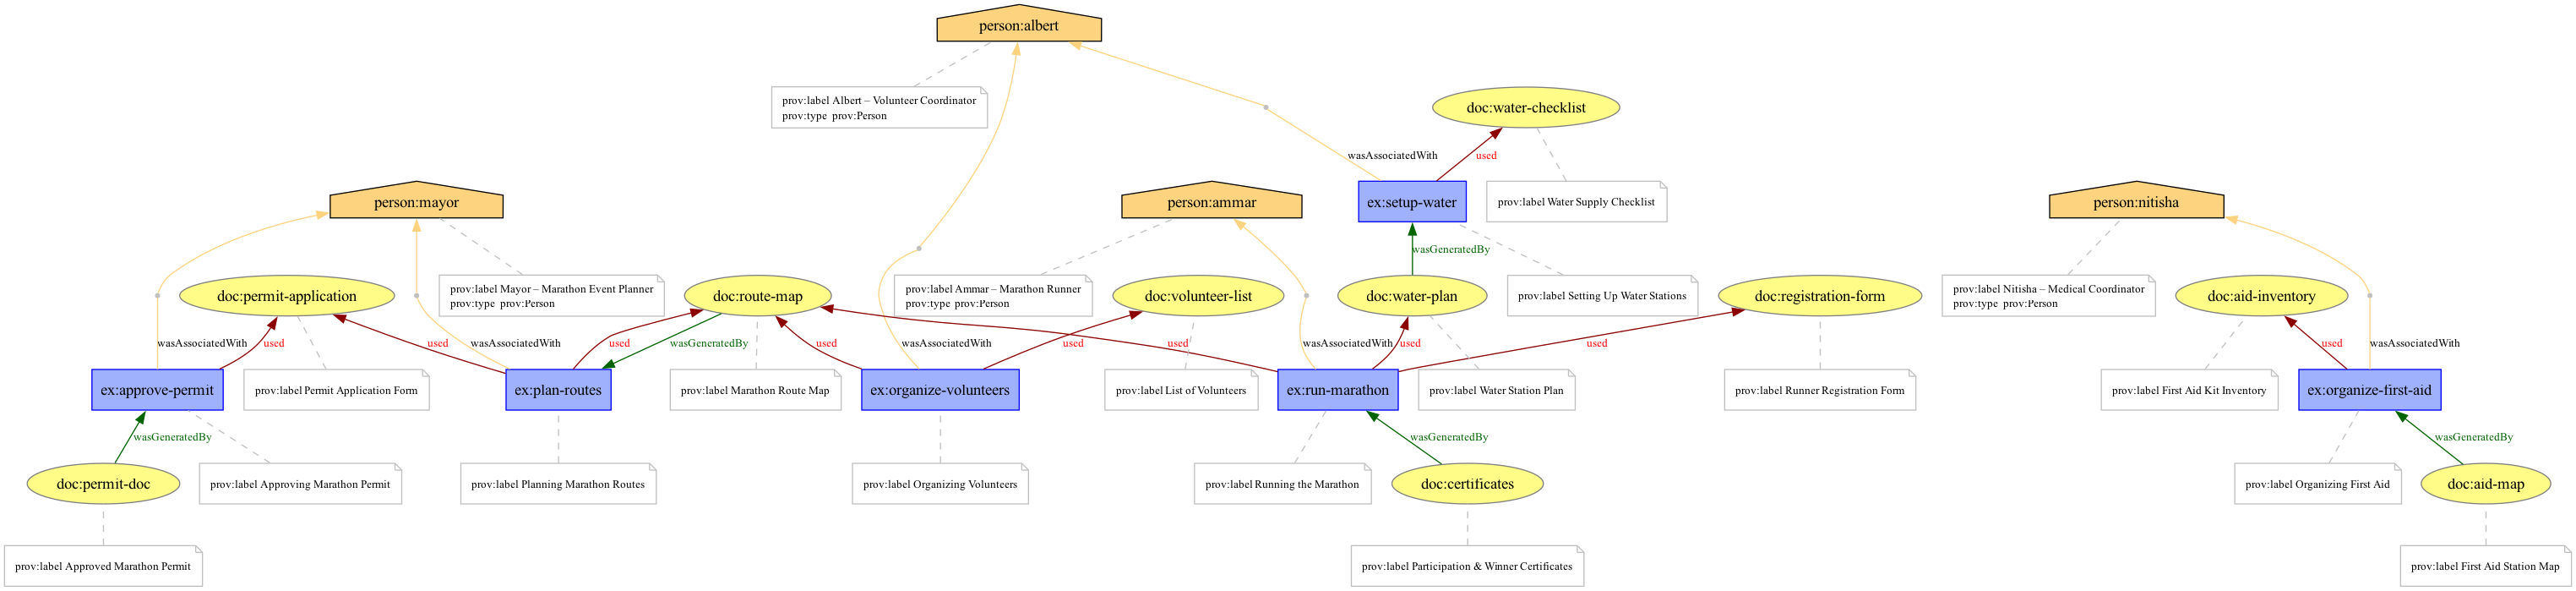

In [190]:
# 📊 Visualize the graph and count nodes

from prov.dot import prov_to_dot
import IPython.display as display

# Creating dot graph and save as PNG
dot = prov_to_dot(d1)
dot.write_png('marathon_provenance.png')

# Displaying the image in the notebook
display.Image('marathon_provenance.png')

In [191]:
from prov.graph import prov_to_graph

# Convert ProvDocument to MultiDiGraph
g = prov_to_graph(d1)

# Output graph data
print(g.number_of_nodes())
print(g.number_of_edges())

20
21


### PageRank Visualization

In this section, we visualize the relative importance of nodes in the provenance network using the PageRank algorithm.

####  Computing and Plotting PageRank

We now compute PageRank values using NetworkX’s built-in pagerank() function with a damping factor α = 0.9.
The graph is then visualized using the plot_pagerank() function to highlight nodes with higher influence.

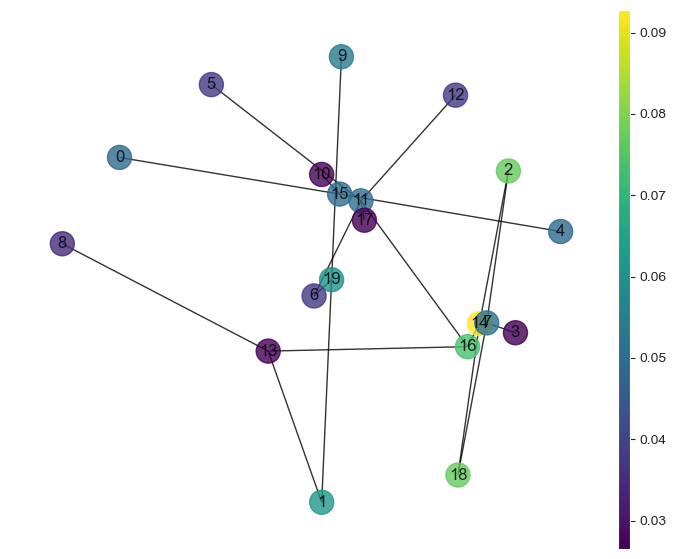

In [ ]:
# Plotting function to visualize PageRank values on the graph
def plot_pagerank(graph, pagerank):
    fig, ax = plt.subplots(1, 1, figsize=(8, 7))

    # Assigning numerical labels for nodes and collect PR values
    labels = dict(zip(set(graph.nodes()), range(len(set(graph.nodes())))))
    node_color = list(pagerank.values())

    # Drawing the graph
    nx.draw(
        graph,
        with_labels=True,
        alpha=0.8,
        arrows=False,
        node_size=300,
        node_color=node_color,
        cmap=plt.cm.viridis,
        labels=labels
    )

    # Adding colorbar legend for PageRank importance
    sm = plt.cm.ScalarMappable(
        cmap=plt.get_cmap('viridis'),
        norm=colors.Normalize(vmin=min(node_color), vmax=max(node_color))
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(sm, cax=cax)
    
    
# Computing PageRank values on the provenance graph
pagerank = nx.pagerank(g, alpha=0.9)

# Plotting PageRank graph

plot_pagerank(g, pagerank)


#### Node Degree vs PageRank Analysis

This scatter plot compares each node’s degree (number of connections) with its PageRank value.

Text(0, 0.5, 'PageRank value')

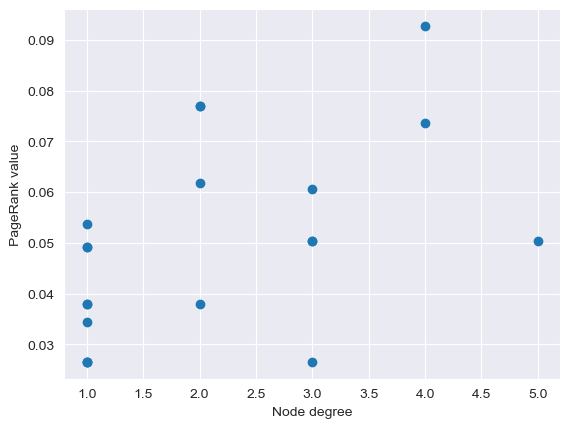

In [ ]:
# Sorting nodes by their PageRank value (descending)
pagerank_sorted_desc = dict(sorted(pagerank.items(), key=lambda item: item[1], reverse=True))

# Getting degree of each node to compare structural position with PageRank
node_degree = {k: v for k, v in g.degree(pagerank_sorted_desc.keys())}

# Preparing data for scatter plot
x = node_degree.values()
y = pagerank_sorted_desc.values()

# Plotting node degree vs PageRank score
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Node degree')
ax.set_ylabel('PageRank value')

### Training and Evalutaion TrasnE, RotatE, CompGCN

In [ ]:
import matplotlib.pyplot as plt
from pykeen.datasets import CoDExMedium
from pykeen.pipeline import pipeline
from pykeen.sampling import BasicNegativeSampler
from pykeen.evaluation import RankBasedEvaluator


from pykeen.triples import TriplesFactory
from pykeen.models import TransE
from pykeen.models import RotatE
from pykeen.models import CompGCN

#### Load CoDExMedium Dataset

In this step, we load the CoDExMedium dataset using PyKEEN’s built-in dataset loader.

In [232]:
dataset = CoDExMedium(create_inverse_triples=False)
dataset.summarize()

CoDExMedium (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    17050       51              185584
Testing     17050       51               10311
Validation  17050       51               10310
Total       -           -               206205
Head    Relation    tail
------  ----------  --------
Q1000   P30         Q15
Q1000   P37         Q150
Q1000   P463        Q1043527
Q1000   P463        Q1065
Q1000   P463        Q134102



In [233]:
dataset.relation_to_id

{'P101': 0,
 'P102': 1,
 'P1050': 2,
 'P1056': 3,
 'P106': 4,
 'P108': 5,
 'P112': 6,
 'P113': 7,
 'P119': 8,
 'P1303': 9,
 'P131': 10,
 'P135': 11,
 'P136': 12,
 'P138': 13,
 'P140': 14,
 'P1412': 15,
 'P159': 16,
 'P161': 17,
 'P17': 18,
 'P172': 19,
 'P19': 20,
 'P20': 21,
 'P2283': 22,
 'P2348': 23,
 'P26': 24,
 'P264': 25,
 'P27': 26,
 'P30': 27,
 'P3095': 28,
 'P3373': 29,
 'P361': 30,
 'P37': 31,
 'P40': 32,
 'P407': 33,
 'P451': 34,
 'P452': 35,
 'P463': 36,
 'P495': 37,
 'P50': 38,
 'P509': 39,
 'P530': 40,
 'P54': 41,
 'P551': 42,
 'P57': 43,
 'P641': 44,
 'P69': 45,
 'P737': 46,
 'P740': 47,
 'P749': 48,
 'P780': 49,
 'P840': 50}

#### Utility Functions for Plotiing and Evaluation Metrics

In [ ]:
# Function to plot loss curves from any PyKEEN pipeline result
def plot_model_loss(pipeline_result, model_name="Model"):
    fig, ax = plt.subplots(figsize=(10, 4))
    pipeline_result.plot_losses()
    plt.title(f"{model_name} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
# Function to display Evaluation metrics
def show_model_metrics(pipeline_result, model_name="Model"):
    mrr = pipeline_result.get_metric('mrr')
    hits_at_10 = pipeline_result.get_metric('hits@k')

    print(f"\n{model_name} Evaluation Results")
    print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
    print(f"Hits@10: {hits_at_10:.4f}")
    

# Converting a PROV graph to a PyKEEN TriplesFactory for downstream evaluation
def prov_to_triples_factory(prov_doc, create_inverse=True):
    triples = []
    for record in prov_doc.get_records():
        if len(record.formal_attributes) >= 2:
            subj = record.formal_attributes[0][1]
            pred = record.get_type().localpart
            obj = record.formal_attributes[1][1]
            triples.append((str(subj), str(pred), str(obj)))
    
    triples_array = np.array(triples, dtype=str)
    return TriplesFactory.from_labeled_triples(
        triples=triples_array,
        create_inverse_triples=create_inverse,
    )
    

# Evaluating a trained model on a custom (e.g. provenance) triples graph
def evaluate_on_provenance_graph(model, triples_factory, modelName=""):
    evaluator = RankBasedEvaluator()
    results = evaluator.evaluate(
        model=model,
        mapped_triples=triples_factory.mapped_triples,
        additional_filter_triples=[],
    )
    
    mrr = results.get_metric('mrr')
    hits10 = results.get_metric('hits@10')
    
    print(f"\n\nEvaluation of {modelName} model on Provenance Graph:")
    print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
    print(f"Hits@10: {hits10:.4f}")


#### Train TransE Model on CoDExMedium

In this step, we train the TransE embedding model using the pipeline() function from PyKEEN. We follow the same structure as used in the NDA Labs week 9.

In [259]:
pipeline_result_transe = pipeline(
    dataset=dataset,
    model=TransE,
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=0.01),
    training_kwargs=dict(num_epochs=128, use_tqdm_batch=False,  batch_size=512 ),
    evaluation_kwargs=dict(use_tqdm=True),
    random_seed=1,
    negative_sampler=BasicNegativeSampler,
    negative_sampler_kwargs=dict(num_negs_per_pos=10),
    training_loop='sLCWA',
    evaluator=RankBasedEvaluator,
)

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/128 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/10.3k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 64.31s seconds


In [246]:
# Train RotatE model
pipeline_result_rotate = pipeline(
    dataset=dataset,
    model='RotatE',
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=0.01),
    training_kwargs=dict(num_epochs=128, batch_size=512, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    negative_sampler_kwargs=dict(num_negs_per_pos=10),
    evaluator=RankBasedEvaluator,
    random_seed=1,
)

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/128 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/10.3k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 73.02s seconds


In [237]:
dataset = CoDExMedium(create_inverse_triples=True)

pipeline_result_compgcn = pipeline(
    dataset= dataset,
    model= CompGCN,
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=0.01),
    training_kwargs=dict(num_epochs=20, batch_size=512, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    random_seed=1,
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator=RankBasedEvaluator,
)

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/724 (0.14%) batches).


Evaluating on cpu:   0%|          | 0.00/10.3k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 9.93s seconds


<!-- #### Plotting Training Loss Curves -->

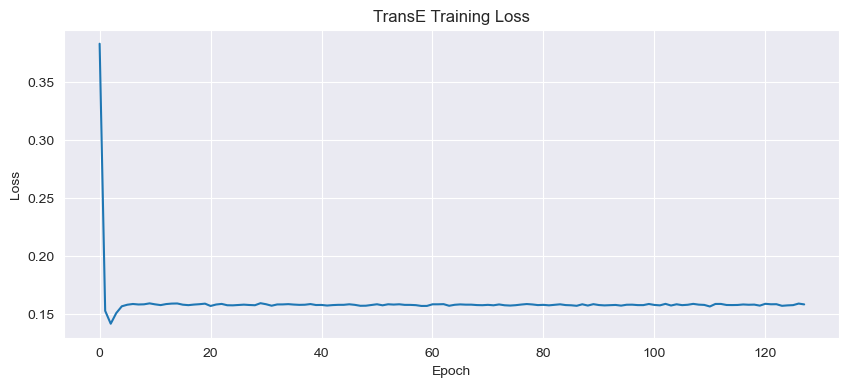

In [260]:
plot_model_loss(pipeline_result_transe, model_name="TransE")

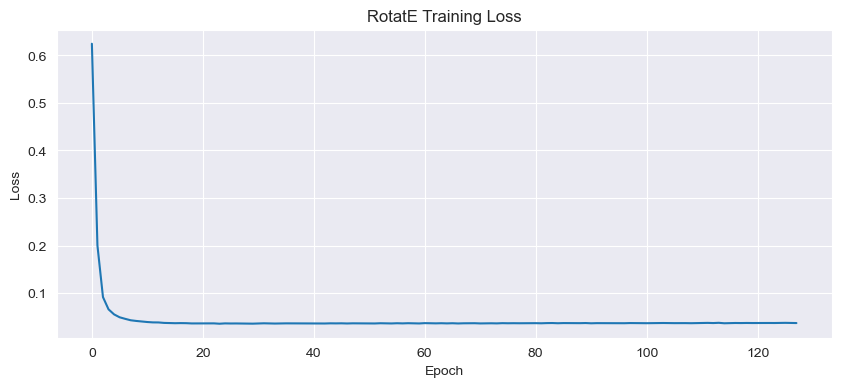

In [261]:
plot_model_loss(pipeline_result_rotate, model_name="RotatE")

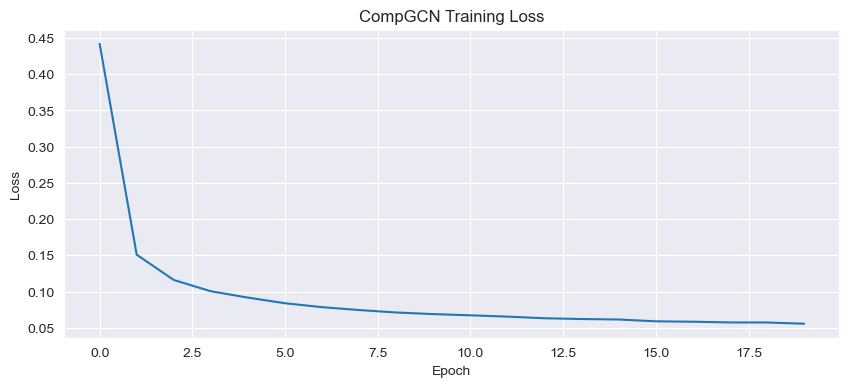

In [262]:
plot_model_loss(pipeline_result_compgcn, model_name="CompGCN")

#### Displaying Evaluation Scores

In [263]:
show_model_metrics(pipeline_result_transe, model_name="TransE")


TransE Evaluation Results
Mean Reciprocal Rank (MRR): 0.0862
Hits@10: 0.1955


In [264]:
show_model_metrics(pipeline_result_rotate, model_name="RotatE")


RotatE Evaluation Results
Mean Reciprocal Rank (MRR): 0.0510
Hits@10: 0.0964


In [265]:
show_model_metrics(pipeline_result_compgcn, model_name="CompGCN")


CompGCN Evaluation Results
Mean Reciprocal Rank (MRR): 0.1542
Hits@10: 0.2844


#### Evaluating Models on Provenance Network

In [266]:
# Convert provenance doc to TriplesFactory
prov_tf = prov_to_triples_factory(d1)

# Evaluate TransE on Provenance
evaluate_on_provenance_graph(pipeline_result_transe.model, prov_tf,"TransE")

Evaluating on cpu:   0%|          | 0.00/22.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.25s seconds




Evaluation of TransE model on Provenance Graph:
Mean Reciprocal Rank (MRR): 0.0022
Hits@10: 0.0000


In [258]:
# Evaluate RotatE on Provenance
evaluate_on_provenance_graph(pipeline_result_rotate.model, prov_tf,"RotatE")

Evaluating on cpu:   0%|          | 0.00/22.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds




Evaluation of RotatE model on Provenance Graph:
Mean Reciprocal Rank (MRR): 0.0003
Hits@10: 0.0000


In [255]:
# Evaluate ComGCN on Provenance
evaluate_on_provenance_graph(pipeline_result_compgcn.model, prov_tf,"CompGCN")

Evaluating on cpu:   0%|          | 0.00/22.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.10s seconds




Evaluation of CompGCN model on Provenance Graph:
Mean Reciprocal Rank (MRR): 0.0003
Hits@10: 0.0000
